In [2]:
# 데이터 불러오기
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from matplotlib import font_manager, rc

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import matplotlib
!sudo apt-get install -y fonts-nanum
!sudo fc_cache -fv
!rm ~/.cache/matplotlib -rf
plt.rc('font', family='NanumBarunGothic')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
sudo: fc_cache: command not found


In [4]:
train = pd.read_csv('/content/drive/MyDrive/PJ2/train.csv')
test = pd.read_csv('/content/drive/MyDrive/PJ2/test.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/PJ2/sample_submission.csv')

In [5]:
train.shape, test.shape

((1205, 12), (50, 10))

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              1205 non-null   object 
 1   요일              1205 non-null   object 
 2   본사정원수           1205 non-null   int64  
 3   본사휴가자수          1205 non-null   int64  
 4   본사출장자수          1205 non-null   int64  
 5   본사시간외근무명령서승인건수  1205 non-null   int64  
 6   현본사소속재택근무자수     1205 non-null   float64
 7   조식메뉴            1205 non-null   object 
 8   중식메뉴            1205 non-null   object 
 9   석식메뉴            1205 non-null   object 
 10  중식계             1205 non-null   float64
 11  석식계             1205 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 113.1+ KB


In [7]:
train.describe()

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계
count,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000
mean,2807.815768,157.913693,241.142739,274.117012,43.506224,890.334440,461.772614
std,171.264404,144.190572,43.532298,246.239651,109.937400,209.505057,139.179202
min,2601.000000,23.000000,41.000000,0.000000,0.000000,296.000000,0.000000
25%,2645.000000,71.000000,217.000000,4.000000,0.000000,758.000000,406.000000
50%,2760.000000,105.000000,245.000000,299.000000,0.000000,879.000000,483.000000
75%,2962.000000,185.000000,272.000000,452.000000,0.000000,1032.000000,545.000000
max,3305.000000,1224.000000,378.000000,1044.000000,533.000000,1459.000000,905.000000


본사시간외근무명령서승인건수 MAX가 1044가 존재, 어느 특정한 날에 바쁜 날이 있음을 추측.

In [8]:
train.isnull().sum()

일자                0
요일                0
본사정원수             0
본사휴가자수            0
본사출장자수            0
본사시간외근무명령서승인건수    0
현본사소속재택근무자수       0
조식메뉴              0
중식메뉴              0
석식메뉴              0
중식계               0
석식계               0
dtype: int64

결측값 없음 확인

In [9]:
#편의상 컬럼 분할
object_columns=train.select_dtypes(include='object').columns.to_list()
numerical_columns=['본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']

In [10]:
#기간을 연월일로 구분
train['일자'] = train['일자'].astype('str')
dates= train['일자'].str.split('-')

train['연'] = dates.str.get(0)
train['월'] = dates.str.get(1)
train['일'] = dates.str.get(2)

test['일자'] = test['일자'].astype('str')
dates= test['일자'].str.split('-')
test['연'] = dates.str.get(0)
test['월'] = dates.str.get(1)
test['일'] = dates.str.get(2)

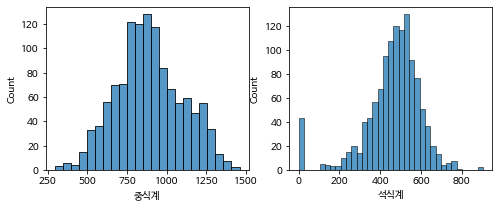

In [11]:
f,ax=plt.subplots(1,2,figsize=(8,3))
sns.histplot(x=train['중식계'], ax=ax[0])
sns.histplot(x=train['석식계'], ax=ax[1]);

TARGET값이 골고루 분포
두 plot의 x축의 값이 다름 주의!
석식계 0이 40건 이상이 있음

In [12]:
train[train['석식계']== 0]

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,연,월,일
204,2016-11-30,수,2689,68,207,0,0.0,모닝롤/카스텔라 우유/주스 스크램블에그 누룽지탕/쌀밥 (쌀:국내산) 고추장찌개 ...,나물비빔밥 (쌀:국내산) 가쯔오장국 치킨핑거*요거트D 감자샐러드 오복지무침 ...,*,1109.0,0.0,2016,11,30
224,2016-12-28,수,2705,166,225,0,0.0,모닝롤/고구마파이 우유/주스 스크램블에그 누룽지탕/쌀밥 (쌀:국내산) 북어계란국 ...,콩나물밥 (쌀:국내산) 가쯔오장국 미트볼케찹조림 꽃맛살샐러드 군고구마 배추겉...,*,767.0,0.0,2016,12,28
244,2017-01-25,수,2697,79,203,0,0.0,모닝롤/토마토샌드 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 두부젓국찌개 ...,카레덮밥 (쌀:국내산) 맑은국 유린기 개성감자만두 오이사과무침 포기김치 (김...,*,720.0,0.0,2017,01,25
262,2017-02-22,수,2632,75,252,0,0.0,모닝롤/브라우니 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 꽃게탕 명엽채...,나물비빔밥 (쌀:국내산) 유부장국 생선까스*탈탈소스 파스타샐러드 마늘쫑볶음 ...,*,1065.0,0.0,2017,02,22
281,2017-03-22,수,2627,53,235,0,0.0,모닝롤/찐빵 우유/주스 계란후라이 김치죽/쌀밥 (쌀:국내산) 콩나물국 김실파무침...,쌀밥/잡곡밥 (쌀:국내산) 돈육김치찌개 유린기 비엔나볶음 세발나물 깍두기 (...,*,953.0,0.0,2017,03,22
306,2017-04-26,수,2626,45,304,0,0.0,모닝롤/와플 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 된장찌개 검정콩조...,비빔밥 (쌀:국내산) 맑은국 오징어튀김 견과류조림 하와이안샐러드 깍두기 (김...,*,835.0,0.0,2017,04,26
327,2017-05-31,수,2637,43,265,0,0.0,모닝롤/베이글 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 두부젓국찌개 자...,열무보리비빔밥 (쌀:국내산) 가쯔오장국 탕수만두 콥샐러드 오이지무침 포기김치...,자기계발의날,910.0,0.0,2017,05,31
346,2017-06-28,수,2648,58,259,0,0.0,모닝롤/단팥빵 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 쇠고기매운국 고...,콩나물밥 (쌀:국내산) 얼갈이된장국 삼치구이 잡채 아삭고추무침 깍두기 (김치...,*자기계발의날*,745.0,0.0,2017,06,28
366,2017-07-26,수,2839,254,246,0,0.0,모닝롤/단팥빵 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 민물새우찌개 숙...,나물비빔밥 미소장국 파스타샐러드 소세지오븐구이 오렌지 포기김치 (김치:국내산),가정의날,797.0,0.0,2017,07,26
392,2017-09-01,금,2642,177,303,45,0.0,모닝롤/단팥빵 우유/주스 계란후라이 단호박죽/쌀밥 (쌀:국내산) 대구찌개 깻순나...,쌀밥/잡곡밥 (쌀:국내산) 시래기국 훈제오리구이 두부구이*양념장 쌈무/양파절임...,*,663.0,0.0,2017,09,01


자기계발의 날, 가정의 날이 있어, 석식계가 0입니다.

첫 행부터 보았을 때, 수요일 기준 11월 30일, 12월 28일, 1월 25일 ... 한 달을 주기로 석식계는 0인 것을 볼 수 있습니다. 특별한 날 인 듯 합니다. 월급날 또는 문화의 날이 아닐까 생각했습니다.

수요일만 있는게 아니라 다른 요일에도 석식계가 0인 것이 보임.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


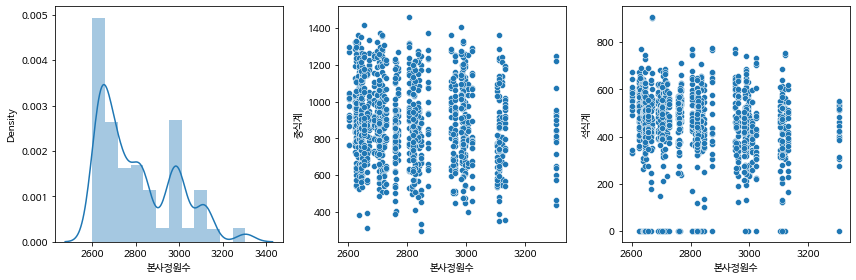

In [13]:
f, ax =plt.subplots(1,3,figsize=(12,4))
sns.distplot(train['본사정원수'],ax=ax[0])
sns.scatterplot(data=train, x='본사정원수',y='중식계',ax=ax[1])
sns.scatterplot(data=train, x='본사정원수',y='석식계',ax=ax[2])

plt.tight_layout()

본사정원수가 증가하고 있음을 볼 수 있습니다.

scatterplot에서 본사의 정원수가 많다고 해서 중식계와 석식계가 크게 증가하지 않았습니다.

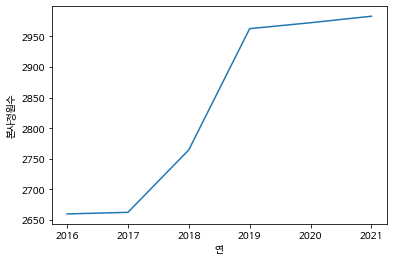

In [14]:
sns.lineplot(data=train, x='연',y='본사정원수',ci=None);

2017년~2019년의 기간동안 대략 300명의 인원을 충원

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


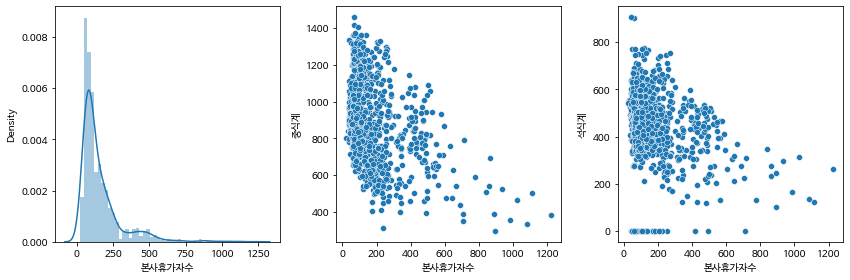

In [15]:
f, ax =plt.subplots(1,3,figsize=(12,4))
sns.distplot(train['본사휴가자수'],ax=ax[0])
sns.scatterplot(data=train, x='본사휴가자수',y='중식계',ax=ax[1])
sns.scatterplot(data=train, x='본사휴가자수',y='석식계',ax=ax[2])

plt.tight_layout()

본사휴가자수와 중식계,석식계 간 음의 관계를 가지고 있음

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


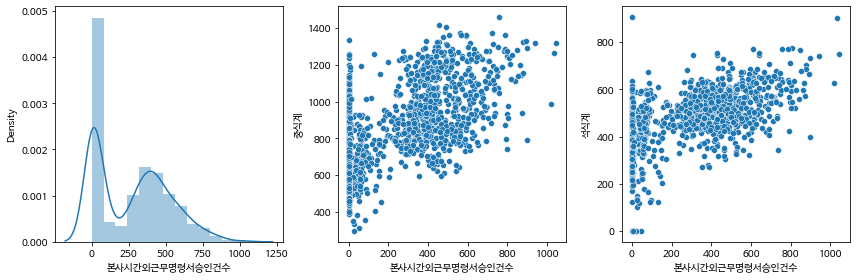

In [16]:
f, ax =plt.subplots(1,3,figsize=(12,4))
sns.distplot(train['본사시간외근무명령서승인건수'],ax=ax[0])
sns.scatterplot(data=train, x='본사시간외근무명령서승인건수',y='중식계',ax=ax[1])
sns.scatterplot(data=train, x='본사시간외근무명령서승인건수',y='석식계',ax=ax[2])

plt.tight_layout()

추가근무(본사시간외근무명령서승인건수)가 있는 날에, 점심,저녁을 챙김

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


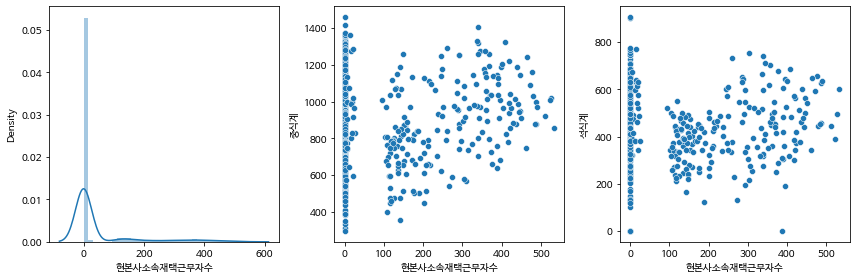

In [17]:
f, ax =plt.subplots(1,3,figsize=(12,4))
sns.distplot(train['현본사소속재택근무자수'],ax=ax[0])
sns.scatterplot(data=train, x='현본사소속재택근무자수',y='중식계',ax=ax[1])
sns.scatterplot(data=train, x='현본사소속재택근무자수',y='석식계',ax=ax[2])

plt.tight_layout()

한동안 재택근무(현본사소속재택근무자수)자 수는 0이었다가 증가

재택근무가 점심과 저녁에는 큰 관계가 없음

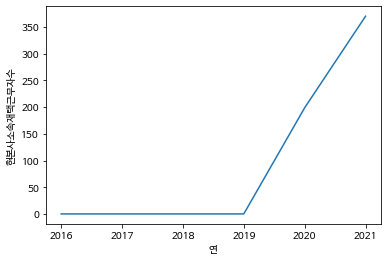

In [18]:
sns.lineplot(data=train, x='연',y='현본사소속재택근무자수',ci=None);

2019년 이후로 재택근무자수가 증가한 것을 볼 수 있는데, 이는 COVID-19로 인해 재택근무자수가 증가

In [19]:
#feature Engineering의 기본, 우선 비율을 추가
train['휴가자비율'] = train['본사휴가자수'] / train['본사정원수']
train['출장자비율'] = train['본사출장자수'] / train['본사정원수']
train['추가근무자비율'] = train['본사시간외근무명령서승인건수'] / train['본사정원수']

test['휴가자비율'] = test['본사휴가자수'] / test['본사정원수']
test['출장자비율'] = test['본사출장자수'] / test['본사정원수']
test['추가근무자비율'] = test['본사시간외근무명령서승인건수'] / test['본사정원수']

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


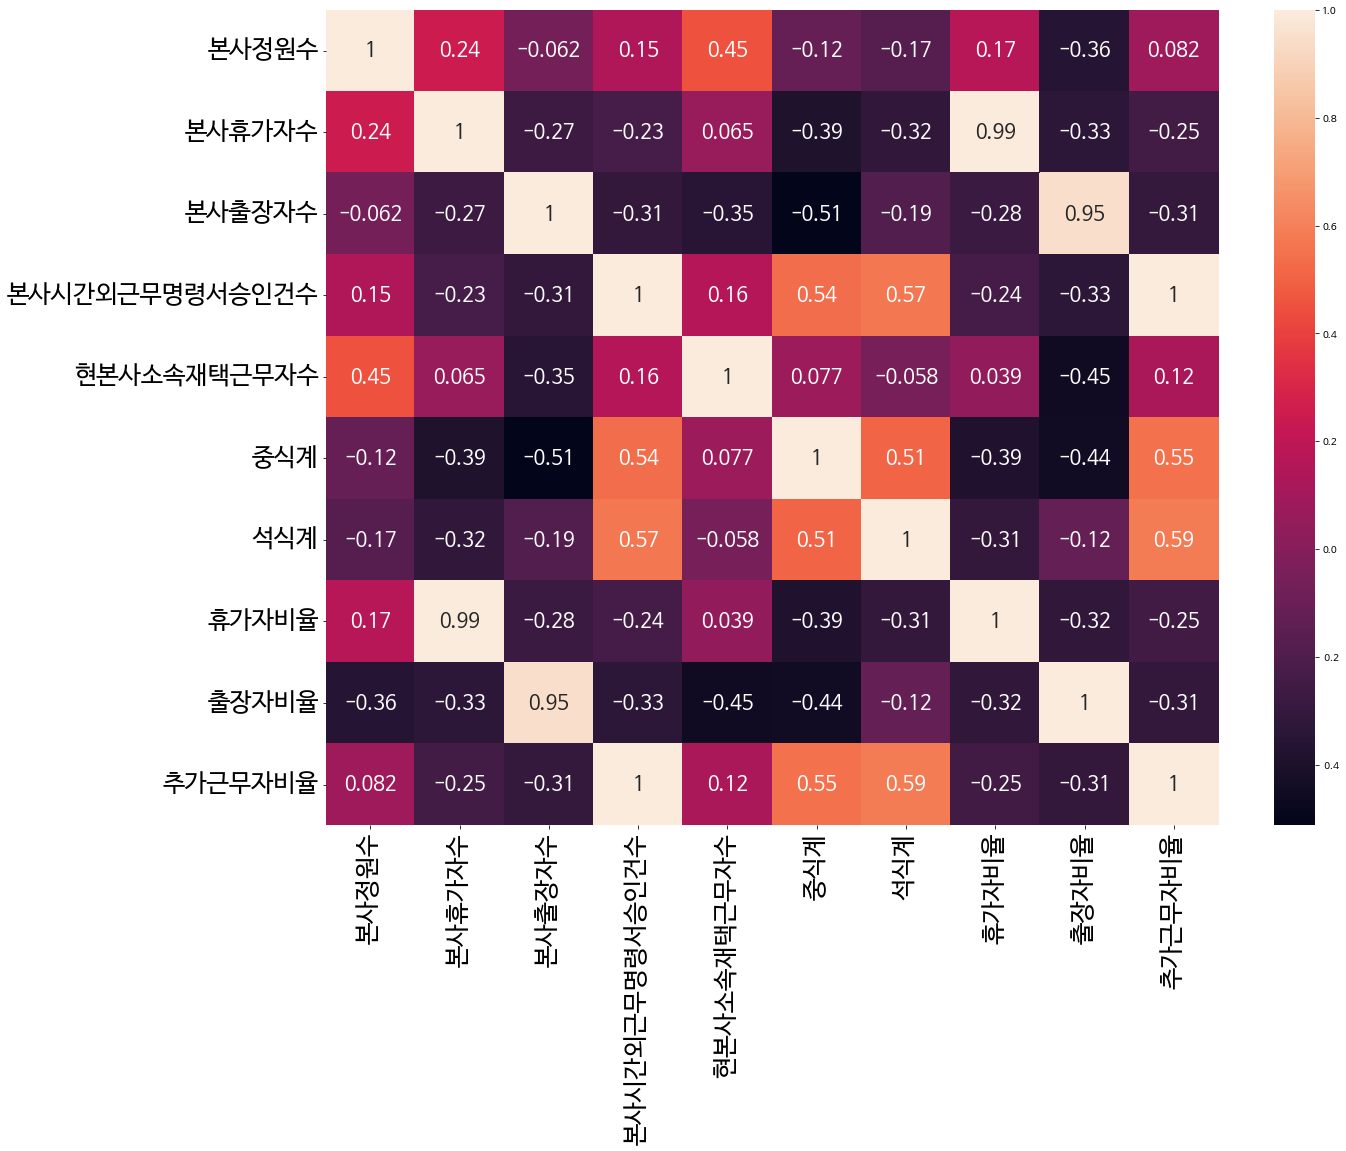

In [20]:
plt.figure(figsize=(20,15))
sns.heatmap(train.corr(), annot=True, annot_kws={'size': 20}) #annot 크기 조정
plt.tick_params(labelsize=25) #label 크기 조정

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.ensemble import  RandomForestRegressor,ExtraTreesRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

In [22]:
object_columns=train.select_dtypes(include='object').columns.to_list()

In [23]:
#label
for i in object_columns:
    le = LabelEncoder()
    train[i] = le.fit_transform(train[i])
    test[i] = le.fit_transform(test[i])

In [24]:
X1 = train.drop(['일자','일','조식메뉴','중식메뉴','석식메뉴','중식계','석식계'], axis=1)
y1 = train.중식계
y2 = train.석식계

test_X = test.drop(['일자','일','조식메뉴','중식메뉴','석식메뉴'],axis=1)

In [25]:
X_train, X_test, y_train,y_test = train_test_split(X1,y1, test_size=.2, random_state=42)
model1 = LGBMRegressor(random_state=42)
model1.fit(X_train,y_train)
print("Model1 Score: ",model1.score(X_test,y_test))
print("MAE:",mean_absolute_error(y_test, model1.predict(X_test)))

X_train, X_test, y_train,y_test = train_test_split(X1,y2, test_size=.2, random_state=42)
model2 = LGBMRegressor(random_state=42)
model2.fit(X_train,y_train)
print("\nModel2 Score: ",model2.score(X_test,y_test))
print("MAE:",mean_absolute_error(y_test, model2.predict(X_test)))

Model1 Score:  0.7904869068531433
MAE: 70.2305369639545

Model2 Score:  0.5090837158007009
MAE: 68.42142406921717


In [26]:
pred1 = model1.predict(test_X)
pred2 = model2.predict(test_X)

In [27]:
submission = sample_submission.copy()
submission['중식계'] = pred1
submission['석식계'] = pred2

In [28]:
submission.to_csv("/content/drive/MyDrive/PJ2/sample_submission.csv",index=False)
submission.head()

,일자,중식계,석식계
0,2021-01-27,1042.970943,407.234194
1,2021-01-28,990.048507,473.237349
2,2021-01-29,645.778892,305.621070
3,2021-02-01,1232.279304,596.678381
4,2021-02-02,999.260236,521.238390


In [29]:
submission.describe()

,중식계,석식계
count,50.000000,50.000000
mean,997.301805,509.740156
std,200.355035,124.712448
min,626.085835,269.070349
25%,908.689506,412.439637
50%,1032.855643,506.110658
75%,1111.681192,613.173783
max,1331.010222,749.061232


코로나가 심해진 2021년 외부 식당을 이용하는 것보다는 구내식당을 이용하는 비율이 증가했을 것으로 판단되었다.